In [1]:
import cobra
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
mod1 = cobra.io.load_json_model('./cerevisiaeMod1.json')
mod1a = cobra.io.load_json_model('./cerevisiaeMod1a.json')
mod2 = cobra.io.load_json_model('./cerevisiaeMod2.json')
mod3 = cobra.io.load_json_model('./cerevisiaeMod3.json')

In [63]:
def escherDF(model, lam, name):
    
    modelCopy = model.copy()
    
    biomass = modelCopy.reactions.BIOMASS_SC5_notrace.flux_expression
    but = modelCopy.reactions.DM_but_c.flux_expression
    
    biomass_but = modelCopy.problem.Objective(biomass + lam*but, direction='max')
    modelCopy.objective = biomass_but
    
    solution = modelCopy.optimize(objective_sense=None)
    
    df = pd.DataFrame.from_dict([solution.fluxes]).T
    df.to_csv( name + '.csv')
    
    return(solution)

Two different regimes for each model: 

- 100% butyrate production
- 50% butyrate production

For models 2 and 3 the 100% biomass production regime is studied because these produce butyrate when biomass is optimized. 

<img src="./plots/lambdaBioBut.png">

In [5]:
def solPath(lams, model, biomass, but):
    
    modelCopy = model.copy()
    
    nlams = len(lams)

    buts = np.repeat(0.0, nlams)
    biomasses = np.repeat(0.0, nlams)


    for i, lam in enumerate(lams):

        biomass_but = modelCopy.problem.Objective(biomass + lam*but, direction='max')

        modelCopy.objective = biomass_but

        solution = modelCopy.optimize(objective_sense=None)

        buts[i] = solution.fluxes.DM_but_c

        biomasses[i] = solution.fluxes.BIOMASS_SC5_notrace  
        
    return({'buts' : buts, 'biomasses' : biomasses})
    

In [6]:
lams = np.arange(0, 0.07, 0.001)

In [7]:
biomass = mod1.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod1.reactions.DM_but_c.flux_expression
pathMod1= solPath(lams, mod1, biomass, but)

In [8]:
biomass = mod1a.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod1a.reactions.DM_but_c.flux_expression
pathMod1a= solPath(lams, mod1a, biomass, but)

In [9]:
biomass = mod2.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod2.reactions.DM_but_c.flux_expression
pathMod2= solPath(lams, mod2, biomass, but)

In [10]:
biomass = mod3.reactions.BIOMASS_SC5_notrace.flux_expression
but = mod3.reactions.DM_but_c.flux_expression
pathMod3= solPath(lams, mod3, biomass, but)

In [37]:
lams

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049, 0.05 , 0.051, 0.052, 0.053,
       0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06 , 0.061, 0.062,
       0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069])

In [32]:
def lamPercentage(path, p):
    
    index = np.argmin(np.abs(path['buts'] - max(path['buts'])*p))
    
    return(lams[index])


In [64]:
l50Mod1 = lamPercentage(pathMod1, 0.5)
l100Mod1 = lamPercentage(pathMod1, 1)

soll50Mod1 = escherDF(mod1, l50Mod1, 'mod1_b50')
soll100Mod1 = escherDF(mod1, l100Mod1, 'mod1_b100')

In [65]:
l50Mod1a = lamPercentage(pathMod1a, 0.5)
l100Mod1a = lamPercentage(pathMod1a, 1)

soll50Mod1a = escherDF(mod1a, l50Mod1a, 'mod1a_b50')
soll100Mod1a = escherDF(mod1a, l100Mod1a, 'mod1a_b100')

In [66]:
l50Mod2 = lamPercentage(pathMod2, 0.5)
l100Mod2 = lamPercentage(pathMod2, 1)

solBioMod2 = escherDF(mod2, 0, 'mod2_biomass')
soll50Mod2 = escherDF(mod2, l50Mod2, 'mod2_b50')
soll100Mod2 = escherDF(mod2, l100Mod2, 'mod2_b100')

In [67]:
l50Mod3 = lamPercentage(pathMod3, 0.5)
l100Mod3 = lamPercentage(pathMod3, 1)

solBioMod3 = escherDF(mod3, 0, 'mod3_biomass')
soll50Mod3 = escherDF(mod3, l50Mod2, 'mod3_b50')
soll100Mod3 = escherDF(mod3, l100Mod2, 'mod3_b100')

## Flux differences

In [102]:
dfMod2 = pd.DataFrame.from_dict([solBioMod2.fluxes, soll50Mod2.fluxes, soll100Mod2.fluxes]).T
dfMod2.columns = ["biomass", "but50", "but100"]

dfMod2['absDiff_bio_but50'] = np.abs(dfMod2['biomass'] - dfMod2['but50'])

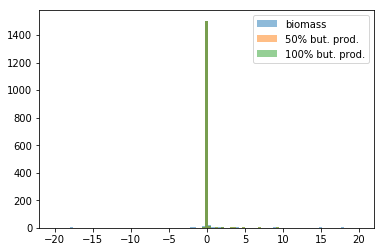

In [114]:
bins = np.linspace(-20, 20, 100)
plt.hist(solBioMod3.fluxes, bins, alpha=0.5, label='biomass')
plt.hist(soll50Mod3.fluxes, bins, alpha=0.5, label='50% but. prod.')
plt.hist(soll50Mod3.fluxes, bins, alpha=0.5, label='100% but. prod.')
plt.legend(loc='upper right')
plt.show()